# Een bewegend golfpakketje

Voor deze opgave gaan we kijken hoe een golfpakketje zich gedraagt als functie van de tijd. We gaan hier niet alleen kijken naar een vrij deeltje, maar ook naar een deeltje dat een potentiaal put of berg tegenkomt. Of meerdere putten en bergen.

De methode die we gebruiken om de Schrodinger vergelijking op te lossen heet de Split Step Fourier Method (SSFM). Dat is een slimme methode om de tijdsafhankelijk SV numeriek op te lossen. Deze methode zit verpakt in de schrodinger.py file in de Schrodinger python class. Ik vind de SSFM een van de coolste methodes die ikzelf heb gezien om numeriek een DV op te lossen, maar in principe kan je deze opdracht doen zonder onder de motorkap te kijken van de oplosmethode. Het gaat ook hier om het bestuderen van quantummechanica - en niet om numerieke methodes.

In [1]:
import numpy as np

from sympy import *
import scipy.integrate as integrate

from matplotlib import pyplot as pl
from matplotlib import animation
from scipy.fftpack import fft,ifft
from IPython.display import HTML

from schrodinger import Schrodinger 

We definieren een golfpakket dat zich op $t=0$ op positie $x_0$ bevindt met breedte $\sigma=a$. Het momentum van het golfpakket is $k_0$. Het golfpakket ziet er dus als volgt uit:

$$\Psi(x) = \frac{1}{\sqrt{\sigma \sqrt{\pi}}} \exp{\left(-\frac{1}{2}\frac{(x-x_0)^2}{\sigma^2}+i k_0 x\right)}$$ 

In [2]:
# Definieer een Gaussisch golfpakket in plaats-representatie
def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """ 
    y = np.zeros(1,dtype=complex)
    return ((a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))

# ... en ook in momentum representatie
def gauss_k(k,a,x0,k0):
    """
    analytical fourier transform of gauss_x(x), above
    """
    return ((a / np.sqrt(np.pi))**0.5* np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0))

**a)** Gebruik de *integrate* functie uit *scipy* om de normalisatie te verifieren van het golfpakket. We gebruiken hier geen symbolische integraties meer uit *sympy*. Deze hele opdracht is een numeriek feestje.

In [3]:
# het reele deel
Re_norm = integrate.quad(lambda x: np.real(gauss_x(x,1.,1.,1.)*np.conjugate(gauss_x(x,1.,1.,1.))),-oo,+oo)[0]
# en het imaginaire deel
Im_norm = integrate.quad(lambda x: np.imag(gauss_x(x,1.,1.,1.)*np.conjugate(gauss_x(x,1.,1.,1.))),-oo,+oo)[0]

print('normalisatie = ',Re_norm," + ",Im_norm,"i")

normalisatie =  1.0  +  0.0 i


In [4]:
######################################################################
# Utility functions for running the animation
def theta(x):
    """
    theta function :
      returns 0 if x<=0, and 1 if x>0
    """
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y

def square_barrier(x, width, height):
    return height * (theta(x) - theta(x - width))+ height *(theta(x-20) - theta(x- 20 -width))

In [5]:
######################################################################
# Create the animation

# specify time steps and duration
dt = 0.01
N_steps = 50
t_max = 200
frames = int(t_max / float(N_steps * dt))

# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

# specify range in x coordinate
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

# specify potential
V0 = 1.5
L = hbar / np.sqrt(2 * m * V0)
a = 3 * L
x0 = -60 * L
V_x = -square_barrier(x, a, V0)
V_x[x < -98] = 1E6
V_x[x > 98] = 1E6

# specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)

k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,
                psi_x0=psi_x0,
                V_x=V_x,
                hbar=hbar,
                m=m,
                k0=-28)

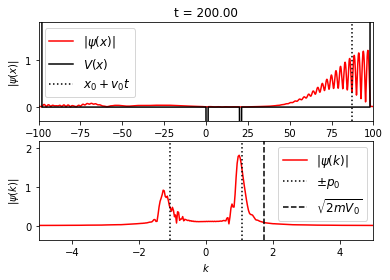

In [6]:
######################################################################
# Set up plot

fig = pl.figure()

# plotting limits
xlim = (-100, 100)
klim = (-5, 5)

# top axes show the x-space data
ymin = 0
ymax = V0
ax1 = fig.add_subplot(211, xlim=xlim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_x_line, = ax1.plot([], [], c='r', label=r'$|\psi(x)|$')
V_x_line, = ax1.plot([], [], c='k', label=r'$V(x)$')
center_line = ax1.axvline(0, c='k', ls=':',
                          label = r"$x_0 + v_0t$")

title = ax1.set_title("")
ax1.legend(prop=dict(size=12))
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|$')

# bottom axes show the k-space data
ymin = abs(S.psi_k).min()
ymax = abs(S.psi_k).max()
ax2 = fig.add_subplot(212, xlim=klim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_k_line, = ax2.plot([], [], c='r', label=r'$|\psi(k)|$')

p0_line1 = ax2.axvline(-p0 / hbar, c='k', ls=':', label=r'$\pm p_0$')
p0_line2 = ax2.axvline(p0 / hbar, c='k', ls=':')
mV_line = ax2.axvline(np.sqrt(2 * V0) / hbar, c='k', ls='--',
                      label=r'$\sqrt{2mV_0}$')
ax2.legend(prop=dict(size=12))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'$|\psi(k)|$')

V_x_line.set_data(S.x, S.V_x)

######################################################################
# Animate plot
def init():
    psi_x_line.set_data([], [])
    V_x_line.set_data([], [])
    center_line.set_data([], [])

    psi_k_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
    V_x_line.set_data(S.x, S.V_x)
    center_line.set_data(2 * [x0 + S.t * p0 / m], [0, 1])

    psi_k_line.set_data(S.k, abs(S.psi_k))
    title.set_text("t = %.2f" % S.t)
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=30, blit=True)


# uncomment the following line to save the video in mp4 format.  This
# requires either mencoder or ffmpeg to be installed on your system

#anim.save('schrodinger_barrier.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

#pl.show()
HTML(anim.to_html5_video())